In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("husl", 10)
!pip install lightgbm
!pip install missingno
!pip install xgboost
import missingno as msno

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import DataConversionWarning
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


     ---------------------------------------- 89.1/89.1 MB 1.8 MB/s eta 0:00:00


In [4]:
train = pd.read_csv('C:/Users/fjmor/Desktop/Data Analysis/EduO/Project/predict-house-prices/train.csv')
test = pd.read_csv('C:/Users/fjmor/Desktop/Data Analysis/EduO/Project/predict-house-prices/test.csv')

In [20]:
train.shape
test.shape
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1379.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,46.549,567.240,1057.429,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,6.518,0.613,1978.506,1.767,472.980,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,161.319,441.867,438.705,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,1.625,0.645,24.690,0.747,213.805,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,1900.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,223.000,795.750,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,5.000,0.000,1961.000,1.000,334.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,0.000,477.500,991.500,1087.000,0.000,0.000,1464.000,0.000,0.000,2.000,0.000,3.000,1.000,6.000,1.000,1980.000,2.000,480.000,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,0.000,808.000,1298.250,1391.250,728.000,0.000,1776.750,1.000,0.000,2.000,1.000,3.000,1.000,7.000,1.000,2002.000,2.000,576.000,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1474.000,2336.000,6110.000,4692.000,2065.000,572.000,5642.000,3.000,2.000,3.000,2.000,8.000,3.000,14.000,3.000,2010.000,4.000,1418.000,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


<AxesSubplot:>

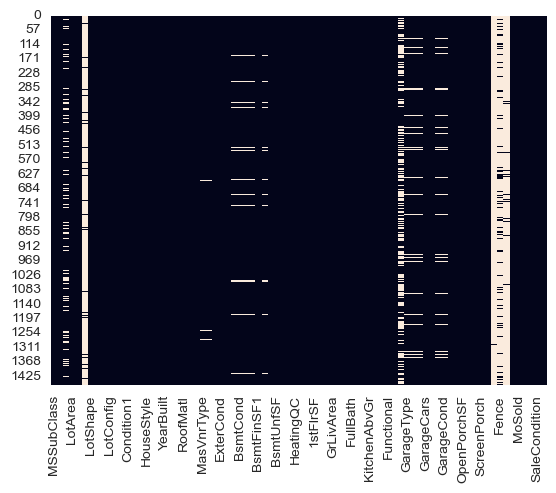

In [21]:
sns.heatmap(train.isnull(),cbar=False)

In [51]:
numerical_cols = [cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']]

In [52]:
numerical_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

<AxesSubplot:>

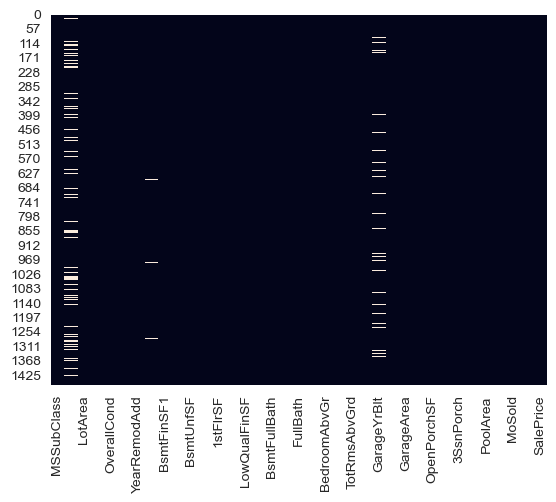

In [29]:
sns.heatmap(train[numerical_cols].isnull(),cbar=False)

In [34]:
train_new = train[numerical_cols]
train_new.isna().sum()

train_new["LotFrontage"] = train_new["LotFrontage"].transform(lambda x: x.fillna(x.median()))
train_new["MasVnrArea"] = train_new["MasVnrArea"].transform(lambda x: x.fillna(x.median()))
train_new["GarageYrBlt"] = train_new["GarageYrBlt"].transform(lambda x: x.fillna(x.median()))


<AxesSubplot:>

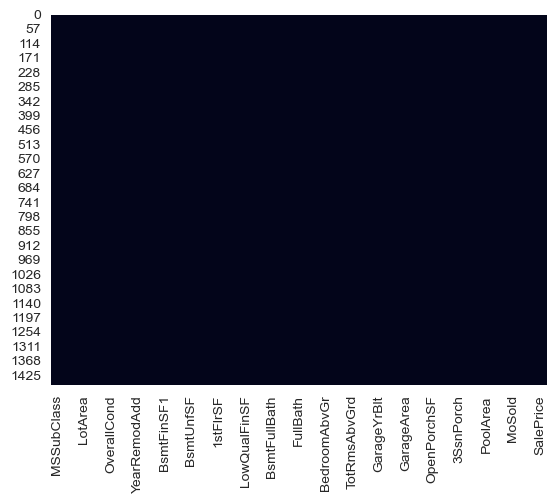

In [35]:
sns.heatmap(train_new.isnull(),cbar=False)

In [62]:
#train_ID = train['Id']
#test_ID = test['Id']

#train_new.drop("Id", axis = 1, inplace = True)
#test.drop("Id", axis = 1, inplace = True)

KeyError: 'Id'

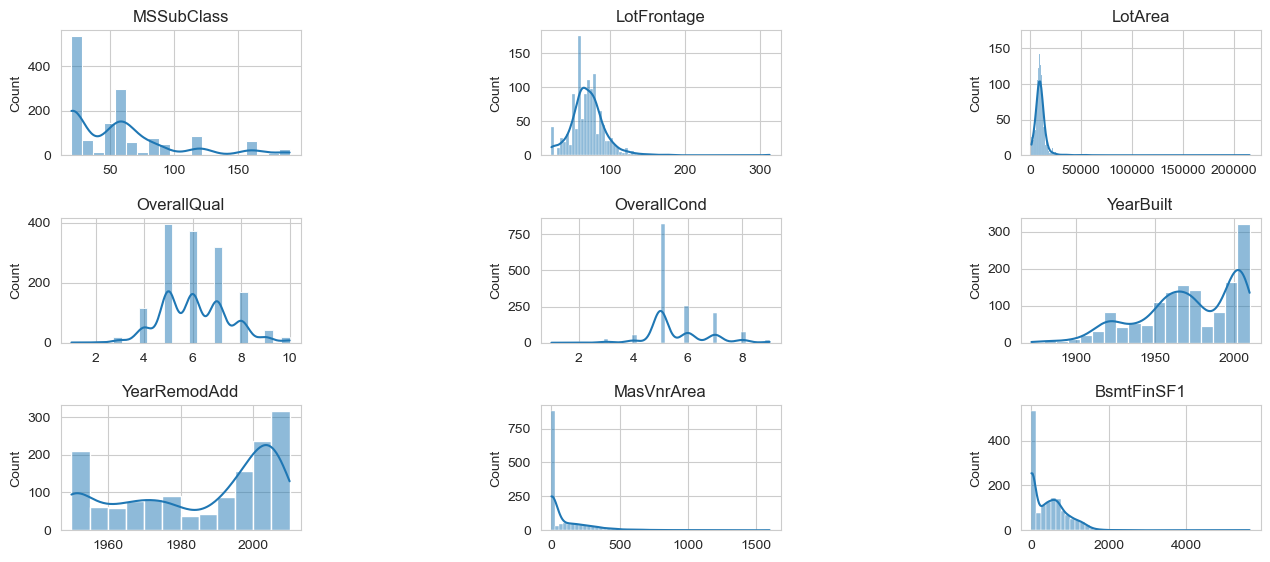

In [36]:
#All graphs

l = train_new.columns.values
number_of_columns=3
number_of_rows = 3

# Figure size (width, height) in inches
fig = plt.figure(figsize=(12, 5))

# Adjust the subplots 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=1)

for i in range(0,9):
    plt.subplot(number_of_rows,number_of_columns,i+1)
    sns.histplot(train[l[i]],kde=True) 
    plt.xlabel('')
    plt.title(l[i])

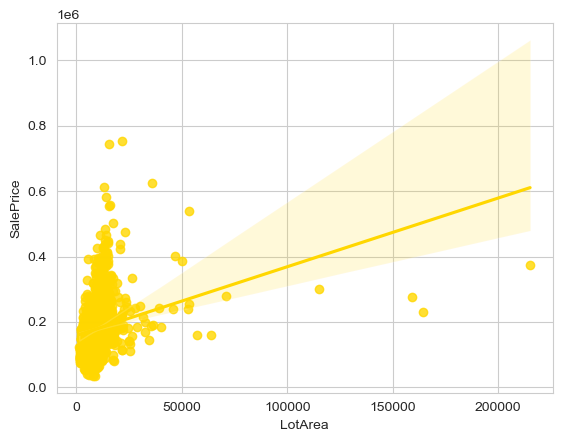

In [26]:
sns.regplot(x = 'LotArea', y = 'SalePrice', color = 'gold', data = train)
plt.show()

In [37]:
lgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=6000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

In [63]:
y_train = train_new.SalePrice.values

kf = KFold(n_splits = 5, shuffle = True, random_state = 123).get_n_splits(train_new.values)

In [64]:
lgbm_mse_cv_scores = - cross_val_score(lgbm, train_new.values,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
lgbm_rmse_score = np.sqrt(lgbm_mse_cv_scores)

print('LightGBM Regressor CV RMSE Score :', lgbm_rmse_score.mean())

LightGBM Regressor CV RMSE Score : 15214.741157021062


In [95]:
#train_new.drop("Id", axis = 1, inplace = True)
test[numerical_cols].columns.difference(train_new.columns)
#train_new.head()
train_new.drop("SalePrice", axis = 1, inplace = True)

print(test[numerical_cols].shape)
print(train_new.shape)



(1459, 36)
(1460, 36)


In [93]:
test[numerical_cols].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,80.000,11622,5,6,1961,1961,0.000,468.000,144.000,270.000,882.000,896,0,0,896,0.000,0.000,1,0,2,1,5,0,1961.000,1.000,730.000,140,0,0,0,120,0,0,6,2010
1,20,81.000,14267,6,6,1958,1958,108.000,923.000,0.000,406.000,1329.000,1329,0,0,1329,0.000,0.000,1,1,3,1,6,0,1958.000,1.000,312.000,393,36,0,0,0,0,12500,6,2010
2,60,74.000,13830,5,5,1997,1998,0.000,791.000,0.000,137.000,928.000,928,701,0,1629,0.000,0.000,2,1,3,1,6,1,1997.000,2.000,482.000,212,34,0,0,0,0,0,3,2010
3,60,78.000,9978,6,6,1998,1998,20.000,602.000,0.000,324.000,926.000,926,678,0,1604,0.000,0.000,2,1,3,1,7,1,1998.000,2.000,470.000,360,36,0,0,0,0,0,6,2010
4,120,43.000,5005,8,5,1992,1992,0.000,263.000,0.000,1017.000,1280.000,1280,0,0,1280,0.000,0.000,2,0,2,1,5,0,1992.000,2.000,506.000,0,82,0,0,144,0,0,1,2010


In [96]:
lgbm.fit(train_new, y_train)
lgbm_train_pred = lgbm.predict(train_new)
lgbm_pred = np.expm1(lgbm.predict(test[numerical_cols].values))
rmse_lgbm = np.sqrt(mean_squared_error(y_train,lgbm_train_pred))
print(rmse_lgbm)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
12038.235525598824


In [ ]:
test_preds = lgbm.predict(test[numerical_cols])
                                           
                                           
output = pd.DataFrame({'Id': test_ID,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)